In [1]:
### LIBRERÍAS

import os
import glob
import numpy as np
from tqdm import tqdm
from PIL import Image
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Paths

BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), '..'))
IMG_TRAIN_DIR = os.path.join(BASE_DIR, 'data', 'output', 'train', 'images')
IMG_TEST_DIR = os.path.join(BASE_DIR, 'data', 'output', 'test', 'images')
LBL_TRAIN_DIR = os.path.join(BASE_DIR, 'data', 'output', 'train', 'labels')
LBL_TEST_DIR = os.path.join(BASE_DIR, 'data', 'output', 'test', 'labels')

# MACHINE LEARNING (CLASIFICACIÓN)

In [3]:
# Función para saber si hay barco
def has_boat(label_path):
    return os.path.exists(label_path) and os.path.getsize(label_path) > 0

# Extraer características HOG usando Pillow
def extract_features(image_path):
    image = Image.open(image_path).convert("L")  # Convertir a escala de grises
    image = image.resize((128, 128))  # Redimensionar
    image_np = np.array(image)

    features, _ = hog(image_np,
                      pixels_per_cell=(8, 8),
                      cells_per_block=(2, 2),
                      visualize=True)
    return features

In [4]:
# Cargar imágenes de entrenamiento
X_train, y_train = [], []
train_image_paths = glob.glob(os.path.join(IMG_TRAIN_DIR, '*.png'))

for img_path in tqdm(train_image_paths, desc="Extrayendo características de entrenamiento"):
    filename = os.path.splitext(os.path.basename(img_path))[0] + '.txt'
    label_path = os.path.join(LBL_TRAIN_DIR, filename)  # Ruta de etiquetas de entrenamiento

    label = int(has_boat(label_path))
    features = extract_features(img_path)

    X_train.append(features)
    y_train.append(label)

X_train = np.array(X_train)
y_train = np.array(y_train)

# Cargar imágenes de prueba
X_test, y_test = [], []
test_image_paths = glob.glob(os.path.join(IMG_TEST_DIR, '*.png'))

for img_path in tqdm(test_image_paths, desc="Extrayendo características de test"):
    filename = os.path.splitext(os.path.basename(img_path))[0] + '.txt'
    label_path = os.path.join(LBL_TEST_DIR, filename)  # Ruta de etiquetas de prueba

    label = int(has_boat(label_path))  # Si tienes etiquetas para test (puedes omitir esto si no las tienes)
    features = extract_features(img_path)

    X_test.append(features)
    y_test.append(label)

X_test = np.array(X_test)
y_test = np.array(y_test)

Extrayendo características de test: 100%|████████████████████████████████████████████| 453/453 [00:48<00:00,  9.31it/s]


In [5]:
# Modelo
model = SVC(kernel='linear', probability=True)
model.fit(X_train, y_train)

# Evaluación en conjunto de prueba
y_pred = model.predict(X_test)

print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred, target_names=["No barco", "Barco"]))


Reporte de clasificación:
              precision    recall  f1-score   support

    No barco       0.58      0.57      0.57       210
       Barco       0.63      0.64      0.64       243

    accuracy                           0.61       453
   macro avg       0.60      0.60      0.60       453
weighted avg       0.61      0.61      0.61       453



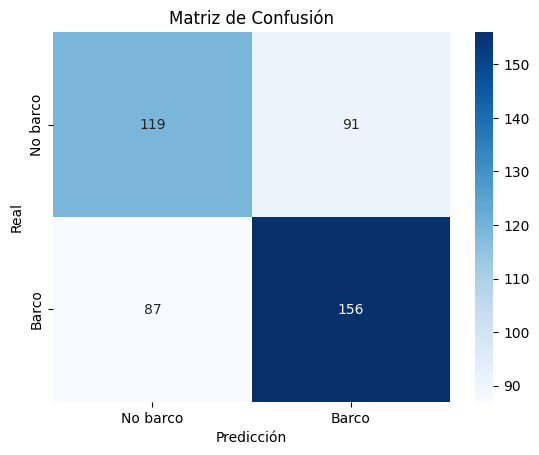

In [6]:
# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No barco", "Barco"], yticklabels=["No barco", "Barco"])
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión")
plt.show()